In [3]:
# Transfer learning : The idea behind transfer learning is simple: instead of learning from a set of filters from scractch
# for our dataset, why not use a set of filters that were learned on a much larger dataset

In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy

In [5]:
pre_trained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150,150,3))

In [6]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [7]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [8]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [9]:
# Lets add our dense layer underneath this pretrained model

In [10]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

In [11]:
# Add a fully connected layer with 1024 hidden units and relu activation
x = layers.Dense(1024, activation='relu')(x)

In [12]:
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

In [13]:
# Compile the model
model = models.Model(pre_trained_model.input, x)


In [14]:
# compile the model
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])

In [15]:
# Prepare the data

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [17]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
import os

def verify_directory_structure(base_dir):
    for split in ['train', 'validation']:
        split_dir = os.path.join(base_dir, split)
        if not os.path.exists(split_dir):
            print(f"Missing directory: {split_dir}")
            return False
        for class_dir in os.listdir(split_dir):
            class_path = os.path.join(split_dir, class_dir)
            if not os.path.isdir(class_path):
                print(f"Expected directory but found file: {class_path}")
                return False
    return True

base_dir = r'C:\Users\Family\DS_PRACTICE\TENSOR_PRACTICE2\data'
if verify_directory_structure(base_dir):
    print("Directory structure is correct.")
else:
    print("Directory structure is incorrect.")


Directory structure is correct.


In [19]:
train_generator = train_datagen.flow_from_directory(
    r'C:\Users\Family\DS_PRACTICE\TENSOR_PRACTICE2\data\train',
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'binary'
)

Found 1027 images belonging to 2 classes.


In [20]:
val_generator = val_datagen.flow_from_directory(
    r'C:\Users\Family\DS_PRACTICE\TENSOR_PRACTICE2\data\validation',
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'binary'
)

Found 256 images belonging to 2 classes.


In [21]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//32,
    epochs=5,
    validation_data=val_generator,
    validation_steps=val_generator.samples//32
)

Epoch 1/5
32/32 [==============================] - 53s 2s/step - loss: 0.1813 - acc: 0.9337 - val_loss: 0.0405 - val_acc: 0.9844
Epoch 2/5
32/32 [==============================] - 57s 2s/step - loss: 0.0537 - acc: 0.9819 - val_loss: 0.0215 - val_acc: 0.9883
Epoch 3/5
32/32 [==============================] - 37s 1s/step - loss: 0.0220 - acc: 0.9940 - val_loss: 0.0243 - val_acc: 0.9922
Epoch 4/5
32/32 [==============================] - 40s 1s/step - loss: 0.0276 - acc: 0.9910 - val_loss: 0.0191 - val_acc: 0.9922
Epoch 5/5
32/32 [==============================] - 70s 2s/step - loss: 0.0105 - acc: 0.9960 - val_loss: 0.0271 - val_acc: 0.9922


In [22]:
# Plot training and validation accuracy and loss


In [23]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Accuracy')

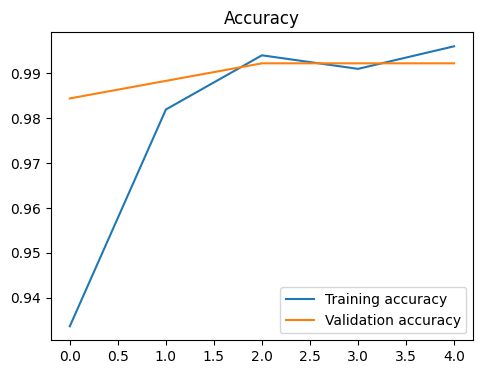

In [29]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label='Training accuracy')
plt.plot(history.history['val_acc'], label='Validation accuracy')
plt.legend()
plt.title('Accuracy')

In [30]:
# TESTING HORSE OR HUMAN IMAGES : Test the model

In [39]:
import numpy as np
from keras.preprocessing import image
import ipywidgets as widgets
from IPython.display import display
from tensorflow.keras.models import load_model

In [ ]:
# File upload widget
upload_widget = widgets.FileUpload(
    accept='image/*',
    multiple=True
)

# Use widget
display(upload_widget)

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

1/1 [==============================] - 1s 1s/step
[[1.]]
[1.]
Screenshot 2024-07-02 111653.png is a human
1/1 [==============================] - 0s 76ms/step
[[1.]]
[1.]
Screenshot 2024-08-01 154249.png is a human
1/1 [==============================] - 0s 46ms/step
[[1.]]
[1.]
Screenshot 2024-07-02 110731.png is a human


In [41]:
def on_upload_change(change):
    for uploaded_file in upload_widget.value:
        # Get the filename and uploaded content of the file
        filename = uploaded_file['name']
        content = uploaded_file['content']

        # Save the uploaded file to the local file system
        with open(filename, 'wb') as f:
            f.write(content)

        # Predicting images
        img = image.load_img(filename, target_size=(150,150))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)

        image_tensor = np.vstack([x])
        classes = model.predict(image_tensor)
        print(classes)

        print(classes[0])
        if classes[0] > 0.5:
            print(filename + ' is a human')
        else:
            print(filename + ' is a horse')

# Handle the fileupload
upload_widget.observe(on_upload_change, names='value')

In [ ]:
# FOR THE SAKE OF SAVING TIME I HAVE KEPT EPOCH TO 5, YOU CAN INCREASE THE VALUE FOR GREATER ACCURACY